<div style="padding:30px; color: white; background-color: #0071CD">
<center>
<img src="img/logoub.jpeg"></img>
<center>
<p>
<h1>Algorítmica Avanzada</h1>
<h2>Práctica 3 - Dynamic Programming </h2>
</center>
</p>
</div>

En esta sesión de programación dinámica veremos únicamente un algoritmo de procesamiento de imágenes. En este notebook se incluyen muchos conceptos que puede que os suenen extraños a día de hoy, sobretodo si no se ha visto tratamiento de imágenes. Independientemente, la única parte del algoritmo que se os pide impementar es aquella que contiene de forma explícita la programación dinámica, así que solo nos hace falta ver la imagen como una matriz de valores y de esta forma podremos trabajar con ella sin demasiado problema.

## 0 Conceptos esenciales

1. __Imágen__: Aunque existen diversas representaciones de una imagen a nivel informático, nosotros trabajaremos con la representación RGB, en la que una imagen de $m \times n$ pixeles se representa con una matriz de $m \times n \times 3$ (Una capa para Red, otra para Green y otra para Blue)
<img src="./img/rgb.png" width=50%>

2. __Gradiente de una imágen__: El gradiente de una imagen es, intuitivamente el valor puntual de la derivada de la imagen en un punto concreto. De forma mas sencilla, el gradiente de una imagen muestra cuanto de diferente es el valor de un pixel respecto a los elementos adyacentes. En una zona en la que el gradiente sea bajo se tratará de una zona homogenea, y una zona de gradiente alto suele indicar un borde.
<img src="./img/grad.png" width=50%>

## 1 Seam Carving
El algoritmo Seam Carving es un algoritmo que nos permite redimensionar imágenes teniendo en cuenta el contenido de la misma.

![Seam Carving](./img/seamcarving.jpg )

El método consite en lo siguiente, dada una imagen cualquiera:
![](./img/sc0.png)
1. Calcular el gradiente horizontal de la imágen en valor absoluto
![](./img/sc1.png)
2. Cómputo de todos los posibles caminos mínimos
![](./img/sc2.png)
3. Obtener el camino mínimo
![](./img/sc3.png)
4. Eliminar el camino mínimo
  

```
import sys
!{sys.executable} -m pip install numpy matplotlib scipy scikit-image
```

In [ ]:
#matplotlib notebook
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd
from skimage import color, data, restoration
from seam_carving_util import rgb2gray, norm, top3, del_path, min_at, mark_path

### 1.1 Caminos mínimos

Para simplificar el ejercicio lo máximo posible los apartados 1 y 4 ya están implementados, en el 2 tendremos que crear una matriz del mismo tamaño de la imagen utilizando la siguiente formulación:

Sean $I$ la matriz con los gradientes de la imagen original y $D$ la imagen generada utilizando Dynamic Programming:

$D_{i,j} = I_{i,j}+\min\Big[D_{i-1, j-1},\quad D_{i-1, j},\quad D_{i-1,j+1}\Big]$

Intuitivamente, calculamos $D_{i,j}$ como la suma de $I_{i,j}$ y el valor mínimo de los tres elementos superiores.

In [ ]:
%matplotlib inline
## Carga la imagen en memoria
print("0. Carga la imagen original")
im = plt.imread('img/beach.jpg') / 255.
plt.imshow(im)
plt.show()

## Aplica un filtro de Sobel para calcular el gradiente
print("1. Calcula el gradiente horizontal de la imagen")
dx = nd.sobel(rgb2gray(im), 1)
plt.imshow(np.abs(dx), cmap='gray')
plt.show()

In [ ]:
def dynamic_programming(mat):
    """
    Se pueden utilizar las funciones importadas del archivo seam_carving_util.py que son:
    - top3: obtiene los tres elementos superiores (es decir, el valor de los 3 elementos superiores)
            de un punto (píxel) en la matriz
    - min_at: obtiene la posición del elemento mas pequeño de un array
    
    
    Nota: Existeix np.argmin
    
    
    Arguments
    ---------
        mat, np.ndarray
            Two dimensional numpy object
        
    Returns
    -------
        np.ndarray
            Numpy array with the same shape as mat
    """
    
    # Init the DP matrix to an empty
    # ndarray with same hsape as mat
    
    dp_mat = np.empty(mat.shape)
    
    # We loop over all the elements of mat
    # and fill the empty ndarray
    
    for i in range(1, dp_mat.shape[0]):
        for j in range(dp_mat.shape[1]):
            dp_mat[i][j] = mat[i][j] + min(top3(dp_mat, [i, j]))
    
    return dp_mat


def min_path_find(mat):
    """
    Find the optimal energy seam in a 
    two dimensional numpy array.
    
    Arguments
    ---------
        mat, np.ndarray
            Two dimensional numpy object
        
    Returns
    -------
        list, of tuples
            Minimal energy seam
    """

    n, m = mat.shape
    
    # We init the path with the minimal
    # energy of the last row of the image
    
    pivot = (n-1, np.argmin(mat[n-1]))
    path = [pivot]
    
    # Loop over all the rows above the last one
    # and without including the first.
    
    for i in range(n-1, 0, -1):
        
        # Compute the left and right boundaries
        # of the superior triplet of pixels
        # Like top3 but considering the indices
        
        t_l = pivot[1] - 1 if pivot[1] > 0 else pivot[1]
        t_r = pivot[1] + 1 if pivot[1] < m - 1 else pivot[1]
        
        # Generate the list of inidices and compute the
        # argmin of them in the matrix, update the pivot
        # with the optimal one
        
        indices = list(zip([i-1 for _ in range(t_l, t_r+1)], list(range(t_l, t_r+1))))
        arg_min = np.argmin(mat[i-1][t_l:t_r+1])
        
        pivot = indices[arg_min] 
        path.append(pivot)
    
    path.reverse()
    return path

In [ ]:
print("2. Calcula la matriz de programación dinámica")
tmp = dynamic_programming(np.abs(dx))

print("3. Busca el camino de mínimo cambio")
path = min_path_find(tmp)
plt.imshow(tmp, cmap='gray')
plt.show()

print("4. Elimina el camino de la imagen")
updated = del_path(im, path) # Updated es ahora la imagen original menos una columna (la eliminada por min_path)
# Muestra el camino eliminado sobre la imágen original
plt.imshow(mark_path(im, path))
plt.show()

### 1.2 Eliminando zonas concretas de una imagen

Ahora suponed que, en lugar de eliminar el camino mínimo de una imagen queremos eliminar un elemento de la imagen sin que se note. Tomad como ejemplo las siguientes dos imágenes.

![](./img/agbar_a.png)
![](./img/agbar_b.jpg)

Alguna idea de como obtener este resultado?

<IPython.core.display.Javascript object>


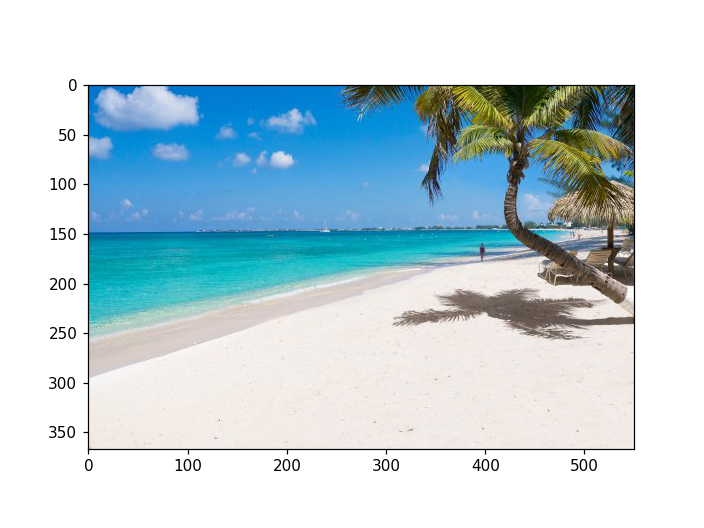

In [2]:
"""
Para que funcionen los siguientes bloques de código, es probable que tengáis que reiniciar el kernel.
Aquí obtenemos las coordenadas de una imagen obteniendo los clicks del usuario sobre esta.
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook

beach = plt.imread('./img/beach.jpg') / 255.
coords = []

def onclick(event):
    print(event)
    global ix, iy
    ix, iy = event.xdata, event.ydata

    global coords
    coords.append((int(ix), int(iy)))
    
    if len(coords) == 2:
        fig.canvas.mpl_disconnect(cid)

    return coords


fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(beach)
cid = fig.canvas.mpl_connect('button_press_event', onclick)

[(384, 152), (405, 181)]


<IPython.core.display.Javascript object>


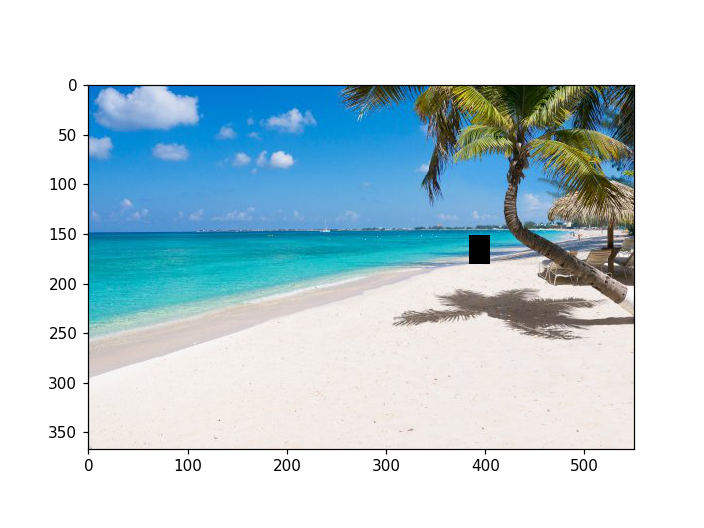

In [3]:
# Ahora le asignamos un peso a la imagen equivalente a -500000 en 
#  cada uno de los puntos de dentro del cuadrado mínimo
print(coords)

def remove_pixels(img, coords):
    img.setflags(write=1)
    coords = [(min(coords[0][0], coords[1][0]), min(coords[0][1], coords[1][1])), 
              (max(coords[0][0], coords[1][0]), max(coords[0][1], coords[1][1]))]
    if len(img.shape) == 2:
        # Cuadrado a negativo grande. Fuerza a los caminos a pasar por ahí.
        img[coords[0][1]:coords[1][1], coords[0][0]:coords[1][0]] = -500000
    else:
        # Cuadrado a 0. Lo ponemos a negro para el display
        img[coords[0][1]:coords[1][1], coords[0][0]:coords[1][0], :] = 0 

    return img

new = remove_pixels(beach, coords)
plt.figure()
plt.imshow(new)

In [ ]:
"""
Implementa las modificaciones necesarias para conseguir eliminar una zona concreta de la imagen.
"""

def removePatch(img, coords):
    return new_img

In [ ]:
# Original image
img = plt.imread('./img/beach.jpg')/255.
plt.figure()
plt.imshow(img)
plt.show()

# Remove patch defined by 'coords'
new = removePatch(img, coords)

# Show modified image
plt.figure()
plt.imshow(new)
plt.show()

<div class="alert alert-info">
<center>
  <h1>Entrega</h1>
</center>
<p>
La entrega de esta práctica se podrá realizar en el campus virtual hasta el día <b>8 de Diciembre a las 23:55</b>. En la tarea que se habilitará en el campus deberéis colgar <b>únicamente este notebook</b> con el nombre:
</p>
<p>
```
[grupo]_[apellido]_[nombre]_3-PD.ipynb
```

</p>
<p>
    Por ejemplo, para un alumno llamado <i>Nombre Genérico</i> perteneciente al <i>grupo Z</i> el nombre del archivo debería ser:
</p>
<p>
```
Z_Generico_Nombre_3-PD.ipynb
```

Y <b>NO</b>:
<ul>
<li>Z00_Generico_Nombre_3-PD.zip</li>
    
<li>ZX_Generico_Nombre_3-PD.ipynb</li>

<li>Lab2_Generico_Nombre_3-PD.rar</li>

<li>3-PD.ipynb</li>
<li> ... literalmente cualquier otra cosa que no sea el nombre que sí hay que ponerle </li>
</ul>
</p>
<p>


Es fundamental que el código esté bién comentado y con un análisis de complejidad exhaustivo del algoritmo. La importancia de poner nombre correcto al archivo debería ser directamente proporcional a lo contentos que queráis que los profesores de prácticas corrijan.<b> No adherirse al formato en el nombre del archivo así como entregar otro tipo de archivo o varios archivos, conllevará a la no corrección de vuestra práctica.</b>
</p>
</div>